# Neccesary modules 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

# Get the data

In [2]:
background = np.load("data/background_rf_LH_normalized.npy")
drone = np.load("data/drone_rf_LH_normalized.npy")

In [3]:
print(background.shape)
print(drone.shape)

(41, 2, 10000000, 1)
(39, 2, 10000000, 1)


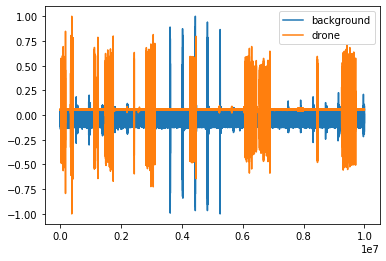

In [4]:
num = random.randint(0, len(background)-1)
channel = 0
plt.plot(background[num][channel], label="background")
plt.plot(drone[num][channel],label="drone")
plt.legend(loc='upper right')

C:\Users\nihad\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


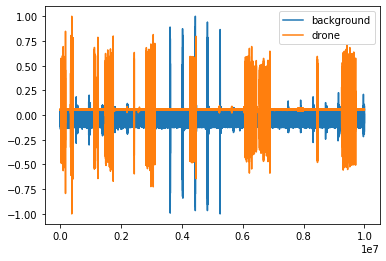

In [5]:
plt.plot(np.fft.rfft(background[num][channel]), label="background")
plt.plot(np.fft.rfft(drone[num][channel]),label="drone")
plt.legend(loc='upper right')

# Train/ test split and data formatting

In [6]:
Y = np.array([0 for i in enumerate(background)] + [1 for i in enumerate(drone)])
X = np.append(background,drone,axis=0)
Y = Y.reshape(-1,1)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [8]:
def split_rf(x_data):
    low = []
    high = []
    for x in x_data:
        low.append(x[0].astype(np.float16))
        high.append(x[1].astype(np.float16))
    low = np.array(low)
    high = np.array(high)
    return [low, high]
x_train = split_rf(x_train)
x_test = split_rf(x_test)
    

# Model Specification

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, concatenate
from tensorflow.keras.layers import Input


# define two sets of inputs
low_rf  = Input(shape=(X.shape[2],))
high_rf = Input(shape=(X.shape[2],))

# the first branch operates on the first input
x1 = Dense(6 , activation="relu")(low_rf)
# x1 = Dense(10, activation="relu")(x1)
x1 = Model(inputs=low_rf, outputs=x1)

# the second branch operates on the second input
x2 = Dense(6 , activation="relu")(high_rf)
# x2 = Dense(10, activation="relu")(x2)
x2 = Model(inputs=high_rf, outputs=x2)

# combine the output of the two branches
combined = concatenate([x1.output, x2.output])

# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(10, activation="relu")(combined)
z = Dense(1, activation="sigmoid")(z)

model = Model(inputs=[x1.input, x2.input], outputs=z)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10000000)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10000000)]   0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 6)            60000006    input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 6)            60000006    input_2[0][0]                    
___________

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, concatenate, Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.layers import Input

pool_size= 50

# define two sets of inputs
low_rf  = Input(shape=(10000000,1,))
high_rf = Input(shape=(10000000,1,))

# the first branch operates on the first input
x1 = Conv1D(filters=32, kernel_size=3, activation='relu')(low_rf)
x1 = MaxPooling1D(pool_size=pool_size)(x1)
x1 = Conv1D(filters=16, kernel_size=3, activation='relu')(x1)
x1 = Dropout(0.5)(x1)
x1 = MaxPooling1D(pool_size=pool_size)(x1)
x1 = Flatten()(x1)
x1 = Dense(50, activation='relu')(x1)
x1 = Model(inputs=low_rf, outputs=x1)

# the second branch operates on the second input
x2 = Conv1D(filters=32, kernel_size=3, activation='relu')(high_rf)
x2 = MaxPooling1D(pool_size=pool_size)(x2)
x2 = Conv1D(filters=16, kernel_size=3, activation='relu')(x2)
x2 = Dropout(0.5)(x2)
x2 = MaxPooling1D(pool_size=pool_size)(x2)
x2 = Flatten()(x2)
x2 = Dense(50, activation='relu')(x2)
x2 = Model(inputs=high_rf, outputs=x2)

# combine the output of the two branches
combined = concatenate([x1.output, x2.output])

# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(10, activation="relu")(combined)
z = Dense(1, activation="sigmoid")(z)

model = Model(inputs=[x1.input, x2.input], outputs=z)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10000000, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10000000, 1) 0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 9999998, 32)  128         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 9999998, 32)  128         input_2[0][0]                    
___________

In [11]:
model.compile(optimizer ='adam' , loss = "binary_crossentropy", metrics=["accuracy"])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Train Model

In [12]:
batch_size =1
epochs = 10
# model.fit(x_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1)
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 56 samples, validate on 24 samples
Epoch 1/10


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[1,1,9999998,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv1d/conv1d-0-0-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[metrics/acc/Identity/_143]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[1,1,9999998,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv1d/conv1d-0-0-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

# Evaluate Model

In [12]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

InternalError: 2 root error(s) found.
  (0) Internal: Dst tensor is not initialized.
	 [[{{node _arg_input_1_0_0}}]]
	 [[metrics/acc/Identity/_105]]
  (1) Internal: Dst tensor is not initialized.
	 [[{{node _arg_input_1_0_0}}]]
0 successful operations.
0 derived errors ignored.

# Free memory

In [ ]:
del X 
del Y
del background
del drone

# Clear GPU

In [ ]:
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del model # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))
    
reset_keras()